# Explore here

In [32]:
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import *
from sklearn.linear_model import OrthogonalMatchingPursuit
from prophet import Prophet
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [6]:
data_sales = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

data_sales.shape

(366, 2)

In [7]:
data_sales.dtypes

date      object
sales    float64
dtype: object

In [8]:
data_sales.isna().sum()

date     0
sales    0
dtype: int64

In [9]:
data_sales.duplicated().sum()

0

In [10]:
data_sales.nunique()

date     366
sales    366
dtype: int64

In [11]:
data_sales.date = pd.to_datetime(data_sales.date)

In [12]:
data_sales

,date,sales
0,2022-09-03 17:10:08.079328,55.29
1,2022-09-04 17:10:08.079328,53.80
2,2022-09-05 17:10:08.079328,58.14
3,2022-09-06 17:10:08.079328,64.53
4,2022-09-07 17:10:08.079328,66.01
...,...,...
361,2023-08-30 17:10:08.079328,989.60
362,2023-08-31 17:10:08.079328,994.99
363,2023-09-01 17:10:08.079328,995.81
364,2023-09-02 17:10:08.079328,997.35


In [13]:
data_sales.set_index('date', inplace=True, drop=True)

In [14]:
data_sales.head()

,sales
date,
2022-09-03 17:10:08.079328,55.29
2022-09-04 17:10:08.079328,53.80
2022-09-05 17:10:08.079328,58.14
2022-09-06 17:10:08.079328,64.53
2022-09-07 17:10:08.079328,66.01


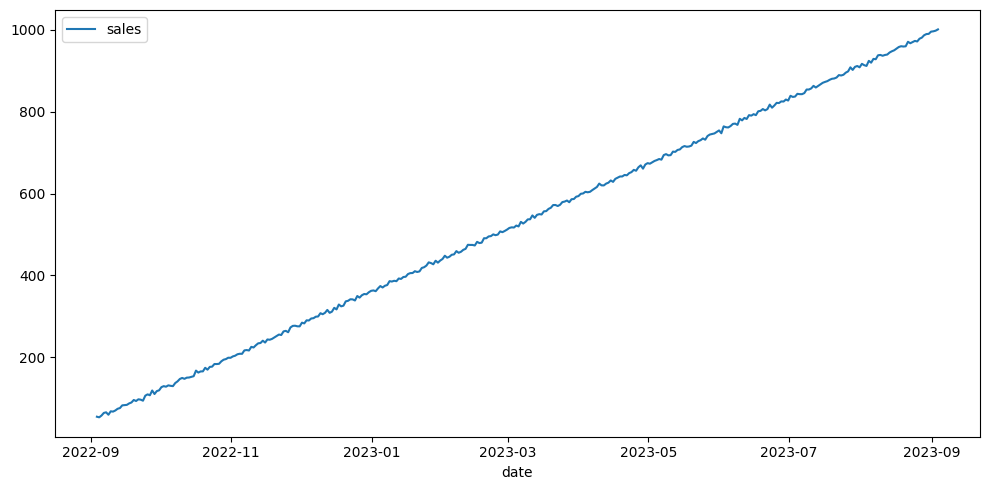

In [24]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = data_sales)

plt.tight_layout()

plt.show()

In [22]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(data_sales)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                  0.55
p-value                         0.99
#Lags Used                     13.00
Number of Observations Used   352.00
Critical Value (1%)            -3.45
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64

In [27]:
decomposition = seasonal_decompose(data_sales)
decomposition

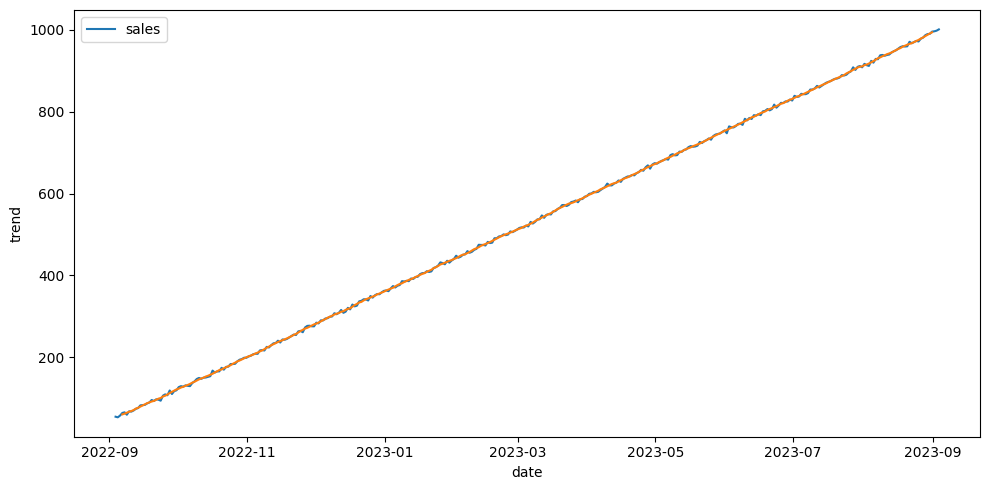

In [28]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = data_sales)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

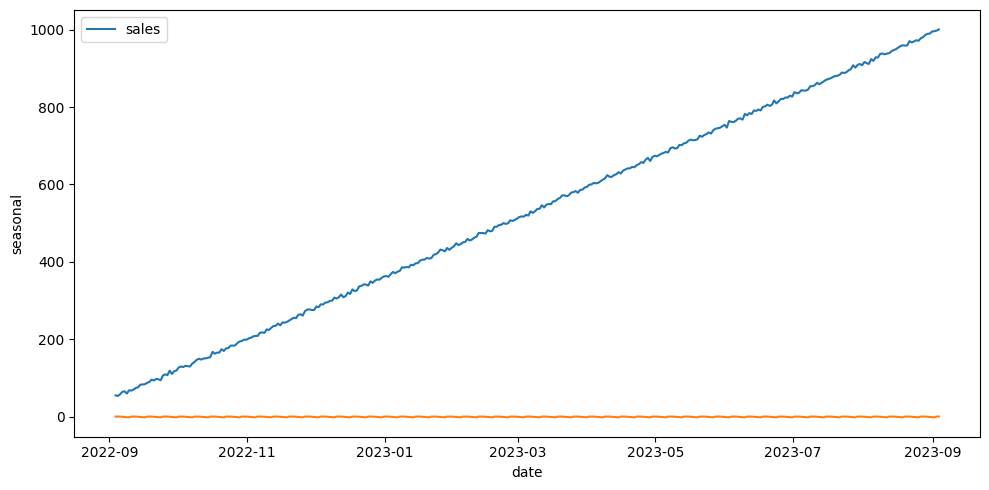

In [29]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = data_sales)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [30]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(data_sales)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                  0.55
p-value                         0.99
#Lags Used                     13.00
Number of Observations Used   352.00
Critical Value (1%)            -3.45
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64

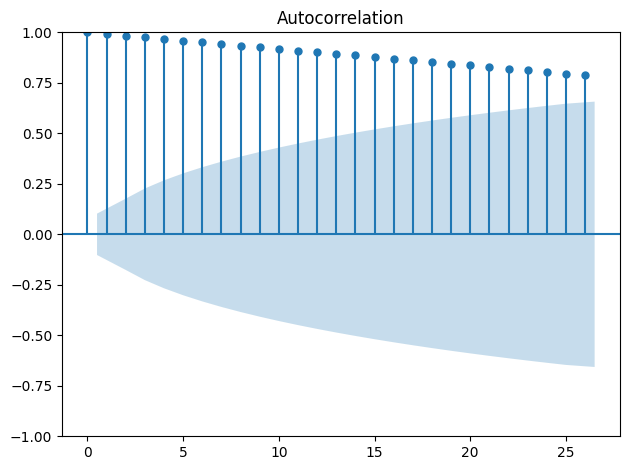

In [33]:
plot_acf(data_sales)

plt.tight_layout()

plt.show()

In [34]:
from prophet import Prophet
data_sales

,sales
date,
2022-09-03 17:10:08.079328,55.29
2022-09-04 17:10:08.079328,53.80
2022-09-05 17:10:08.079328,58.14
2022-09-06 17:10:08.079328,64.53
2022-09-07 17:10:08.079328,66.01
...,...
2023-08-30 17:10:08.079328,989.60
2023-08-31 17:10:08.079328,994.99
2023-09-01 17:10:08.079328,995.81


In [35]:
# Ajustamos un modelo de Prophet con el dataframe creado para la serie temporal
model = Prophet().fit(pd.DataFrame({'ds': data_sales.index, 'y': data_sales.sales.values}))


14:09:51 - cmdstanpy - INFO - Chain [1] start processing
14:09:51 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
df_future = model.make_future_dataframe(periods=len(data_sales[:60]), freq='d')

In [37]:
forecast = model.predict(df_future)

In [38]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-09-03 17:10:08.079328,52.38,49.38,56.53,52.38,52.38,0.65,0.65,0.65,0.65,0.65,0.65,0.00,0.00,0.00,53.03
1,2022-09-04 17:10:08.079328,54.90,51.99,59.02,54.90,54.90,0.63,0.63,0.63,0.63,0.63,0.63,0.00,0.00,0.00,55.52
2,2022-09-05 17:10:08.079328,57.41,54.46,61.45,57.41,57.41,0.54,0.54,0.54,0.54,0.54,0.54,0.00,0.00,0.00,57.96
3,2022-09-06 17:10:08.079328,59.93,56.46,63.72,59.93,59.93,0.14,0.14,0.14,0.14,0.14,0.14,0.00,0.00,0.00,60.07
4,2022-09-07 17:10:08.079328,62.45,58.60,65.78,62.45,62.45,-0.20,-0.20,-0.20,-0.20,-0.20,-0.20,0.00,0.00,0.00,62.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,2023-10-29 17:10:08.079328,1144.33,1140.56,1148.83,1142.18,1146.12,0.63,0.63,0.63,0.63,0.63,0.63,0.00,0.00,0.00,1144.96
422,2023-10-30 17:10:08.079328,1146.93,1143.21,1151.37,1144.73,1148.78,0.54,0.54,0.54,0.54,0.54,0.54,0.00,0.00,0.00,1147.47
423,2023-10-31 17:10:08.079328,1149.52,1145.28,1153.42,1147.23,1151.42,0.14,0.14,0.14,0.14,0.14,0.14,0.00,0.00,0.00,1149.66
424,2023-11-01 17:10:08.079328,1152.11,1147.58,1155.91,1149.73,1154.06,-0.20,-0.20,-0.20,-0.20,-0.20,-0.20,0.00,0.00,0.00,1151.91


In [39]:
yhat_test_pro = forecast.yhat[-len(data_sales.values):]

In [40]:
print(r2_score(data_sales,yhat_test_pro), mean_absolute_percentage_error(data_sales,yhat_test_pro)*100, mean_absolute_error(data_sales,yhat_test_pro))

0.6775920836614824 49.1525584276667 155.95185303806554


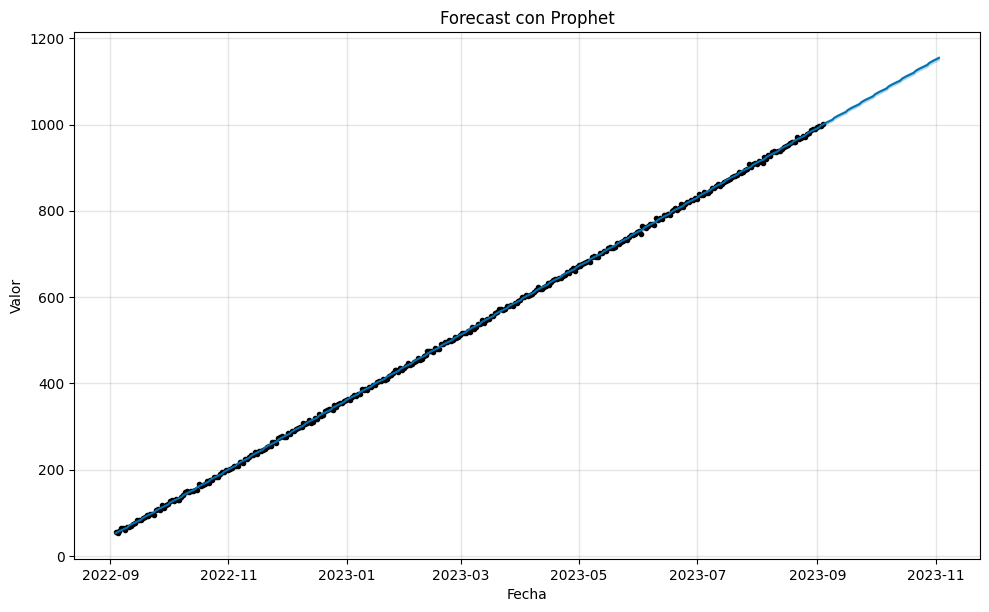

In [41]:
model.plot(forecast)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Forecast con Prophet')
plt.show()

In [42]:
forecast.isna().sum()

ds                            0
trend                         0
yhat_lower                    0
yhat_upper                    0
trend_lower                   0
trend_upper                   0
additive_terms                0
additive_terms_lower          0
additive_terms_upper          0
weekly                        0
weekly_lower                  0
weekly_upper                  0
multiplicative_terms          0
multiplicative_terms_lower    0
multiplicative_terms_upper    0
yhat                          0
dtype: int64

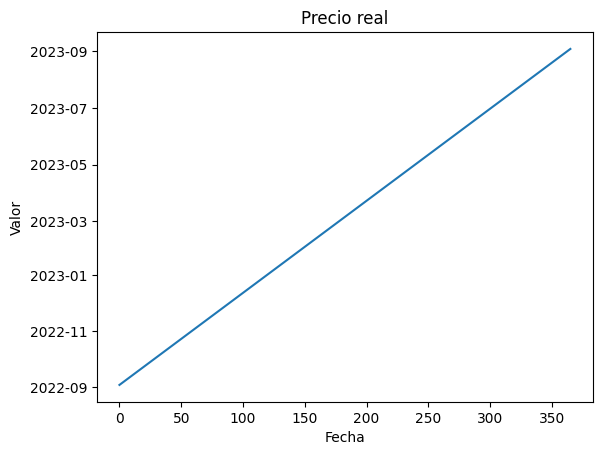

In [43]:
plt.plot(data_sales.index)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Precio real')
plt.show()

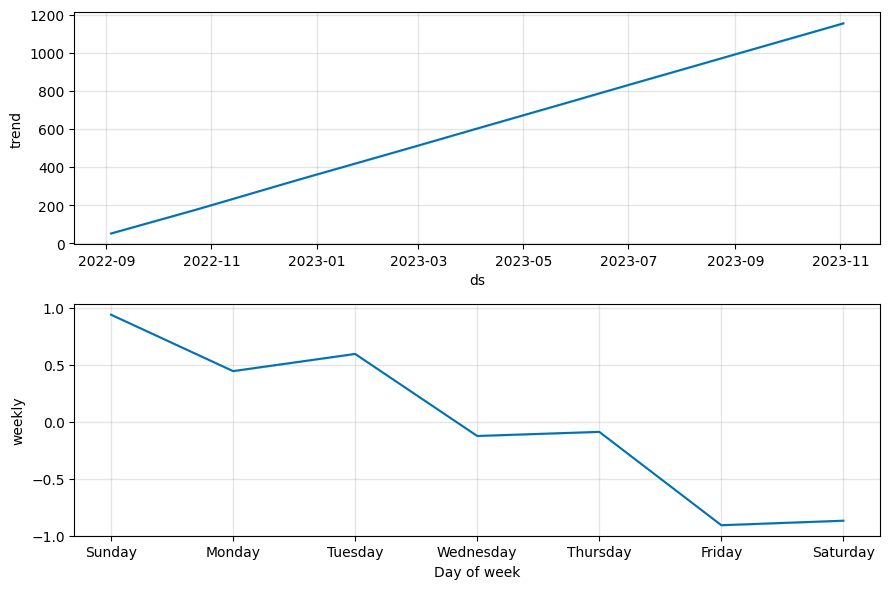

In [44]:
# Descomponer la serie y visualizar las componentes
model.plot_components(forecast)
plt.show()

In [45]:
model = auto_arima(data_sales, seasonal = False, trace = True, m = 7)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.332 seconds


In [46]:
forecast = model.predict(20)
forecast

2023-09-04 17:10:08.079328   1002.16
2023-09-05 17:10:08.079328   1004.83
2023-09-06 17:10:08.079328   1007.42
2023-09-07 17:10:08.079328   1010.02
2023-09-08 17:10:08.079328   1012.62
2023-09-09 17:10:08.079328   1015.22
2023-09-10 17:10:08.079328   1017.82
2023-09-11 17:10:08.079328   1020.41
2023-09-12 17:10:08.079328   1023.01
2023-09-13 17:10:08.079328   1025.61
2023-09-14 17:10:08.079328   1028.21
2023-09-15 17:10:08.079328   1030.80
2023-09-16 17:10:08.079328   1033.40
2023-09-17 17:10:08.079328   1036.00
2023-09-18 17:10:08.079328   1038.60
2023-09-19 17:10:08.079328   1041.20
2023-09-20 17:10:08.079328   1043.79
2023-09-21 17:10:08.079328   1046.39
2023-09-22 17:10:08.079328   1048.99
2023-09-23 17:10:08.079328   1051.59
Freq: D, dtype: float64

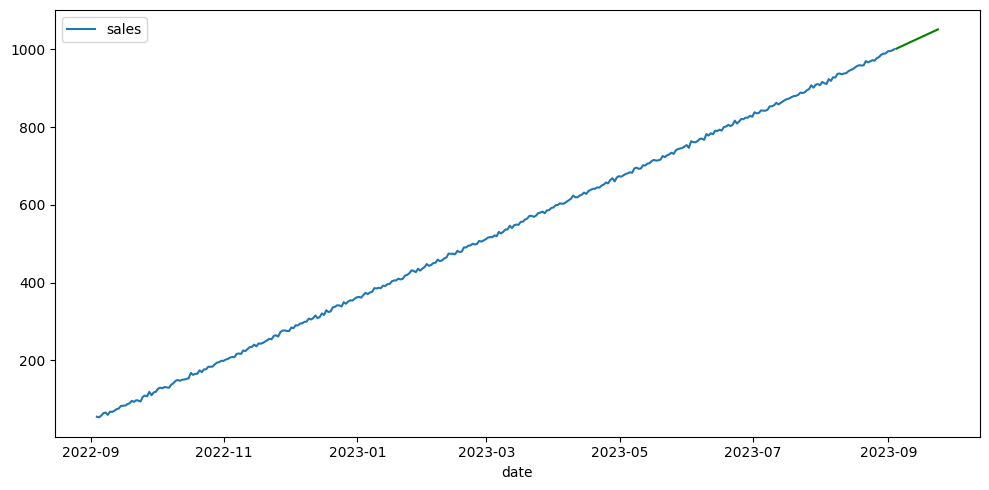

In [47]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = data_sales)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()